# Исследовательский проект по курсу вычислительной математики
## Барсегян Сергей Симоночи 685 гр.




Волновое уравнение с импульсным источником на плоскости։ Числовая дисперсия, угловая зависимость числовой дисперсии метода конечных разностей, анализ Неймана, Псевдоспектральный метод Фурье

In [35]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from ricker import ricker


In [36]:
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

In [37]:
#Initialization
# ---------------------------------------------------------------
nt    = 600     # number of time steps
nx    = 256     # number of grid points in x 
nz    = nx      # number of grid points in z
c     = 343.    # acoustic velocity
eps   = .2      # stability limit
isnap = 600     # snapshot frequency
isx   = int(nx/2)   # source location
isz   = int(nz/2)
f0    = 200.    # Frequency (div by 5)
xmax  = 200
iplot = 20

# initialization of pressure fields
ap = np.zeros((nx, nz), dtype=float)
apnew = np.zeros((nx, nz), dtype=float)
apold = np.zeros((nx, nz), dtype=float)
ad2px = np.zeros((nx, nz), dtype=float)
ad2pz = np.zeros((nx, nz), dtype=float) 
 
sp = np.zeros((nx, nz), dtype= float)
spnew = np.zeros((nx, nz), dtype=float)
spold = np.zeros((nx, nz), dtype=float)
sd2px = np.zeros((nx, nz), dtype=float)
sd2pz = np.zeros((nx, nz), dtype=float); 

sp_sec = -np.abs(sp[1:int(nx/2), 1:int(nz/2)])
ap_sec = -np.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)

dx = xmax/(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx # initialize space coordinates
z  = np.arange(0, nx)*dx # initialize space coordinates
dt = eps*dx/c # calculate tim step from stability criterion

In [38]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(dt, T0*5, peak_loc=0.25/100)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# spatial source function
# ---------------------------------------------------------------
sg = np.zeros((nx, nz), dtype= float)
sigma = 1.5*dx
x0 = x[isx-1] 
z0 = z[isz-1] 
for i in range(nx):
    for j in range(nz):
        sg[i,j] = np.exp(-1/sigma**2 * ((x[i]-x0)**2 +(z[j]-z0)**2))
        
sg = sg/np.amax(sg)

<IPython.core.display.Javascript object>


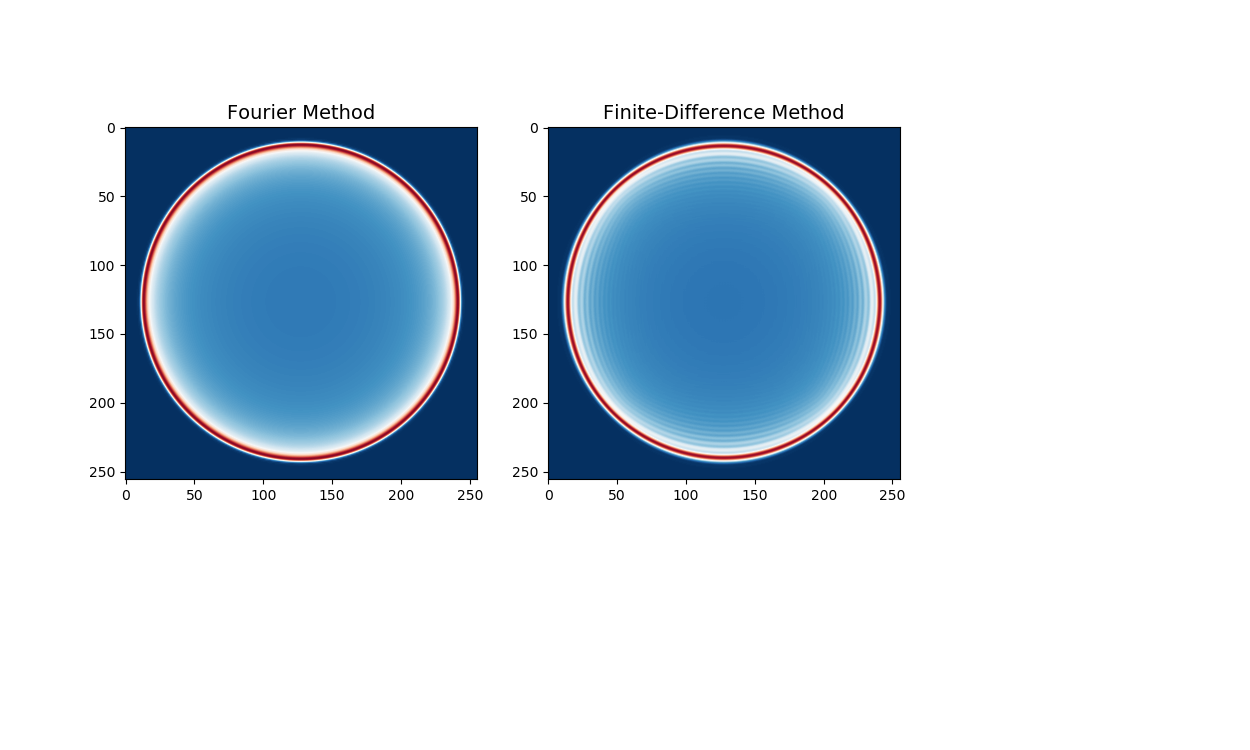

In [39]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
line1 = ax1.imshow(sp_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
line2 = ax2.imshow(ap_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
ax1.set_title('Fourier Method', size=14)
ax2.set_title('Finite-Difference Method', size=14)

plt.ion()   # set interective mode
plt.show()


In [40]:
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    # 2nd space derivative
    for j in np.arange(nz):           
        sd2px[:,j] = fourier_derivative_2nd(sp[:,j].T, dx) 
    for i in np.arange(nx):           
        sd2pz[i,:] = fourier_derivative_2nd(sp[i,:], dx)
        
    # Time Extrapolation
    spnew = 2*sp - spold + c**2 * dt**2 * (sd2px + sd2pz)    
    spnew = spnew + sg*src[it]*dt**2 # Add sources   
    spold, sp = sp, spnew # Time levels
    
    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    for i in range(2, nz-2):
        ad2px[i,:] = (-1./12*ap[i+2,:] + 4./3*ap[i+1,:] - 5./2*ap[i,:] \
                      + 4./3*ap[i-1,:] - 1./12*ap[i-2,:])/dx**2 # Space derivative 
    for i in range(2, nx-2):
        ad2pz[:,i] = (-1./12*ap[:,i+2] + 4./3*ap[:,i+1] - 5./2*ap[:,i] \
                      + 4./3*ap[:,i-1] - 1./12*ap[:,i-2])/dx**2 # Space derivative 
        
    apnew = 2*ap - apold + dt**2 * c**2 * (ad2px + ad2pz) # Time Extrapolation    
    apnew = apnew + sg*src[it]*dt**2 # Add source    
    apold, ap = ap, apnew # Time levels
    
    # Select Sections for plotting
    sp_sec = -np.abs(sp[:,:])
    ap_sec = -np.abs(ap[:,:].T)
    
    # --------------------------------------  
    # Animation plot. Display solution  
    # --------------------------------------
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        line1 = ax1.imshow(sp_sec, interpolation="bicubic", cmap=plt.cm.RdBu) 
        line2 = ax2.imshow(ap_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()
     